In [150]:
# 共通で利用するライブラリ
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# この章で利用するライブラリ
import networkx as nx

# 8章 数値シミュレーションで消費者行動を予測する10本ノック

ここでは、消費者行動が口コミなどの情報伝播によってどのように変化していくかを分析する。 
人間関係のネットワーク構造を用いた数値シミュレーション手法を中心に学んでいく。

前提条件

- links.csv
  - リピーター20人のSNSでのつながり
  - つながりのある組合せあり:1、 つながりのある組合せなし:0
- links_members.csv
  - 全リピーター540人のSNSでのつながり
- info_members.csv
  - 全リピーター540人の2年間の利用状況（月別）
  - 利用がある月:1、利用がない月:0

### Knock71: 人間関係のネットワークを可視化する

- 消費者の口コミによる行動分析
- あるSNSでつながる20人データを分析する

In [151]:
# データの読み込み

# 1: SNS上で「つながっている」
# 0: SNS上で「つながっていない」

df_links = pd.read_csv("../support/8章/links.csv", index_col="Node")
print(df_links.shape)
display(df_links)

(20, 20)


,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,Node10,Node11,Node12,Node13,Node14,Node15,Node16,Node17,Node18,Node19
Node,,,,,,,,,,,,,,,,,,,,
Node0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Node1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
Node2,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
Node3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
Node4,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0
Node5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Node6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Node7,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
Node8,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0


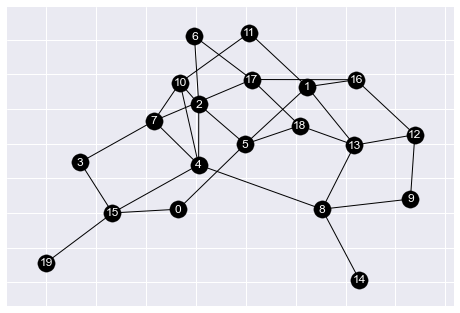

In [152]:
# ネットワークの可視化

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for node in df_links.index:
    node_num = node.strip("Node")
    G.add_node(str(node_num))

# 辺の設定
for node_row in df_links.index:
    for node_col in df_links.columns:
        if df_links.loc[node_row, node_col] == 1:
            G.add_edge(
                str(node_row.strip("Node")), str(node_col.strip("Node"))
            )

# 描画
nx.draw_networkx(
    G,
    node_color="k",
    edge_color="k",
    font_color="w"
)
plt.show()

### Knock72: 口コミによる情報伝播の様子を可視化する

- 仮定
  - 「10のつながりのうち、10％の確率で口コミが伝播していく」

In [153]:
# 口コミ伝播をシミュレートする

def determine_link(percent: float):
    """確率的に口コミをでんぱさせるかどうかを決める"""
    rand_val = np.random.rand()
    if rand_val <= percent:
        return 1
    else:
        return 0

def simulate_percolation(num: int, list_active: list, percent_percolation: float):
    for i in range(num):
        if list_active[i] == 1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links[node_name].iloc[i] == 1:
                    if determine_link(percent_percolation) == 1:
                        list_active[j] = 1
    return list_active

In [154]:
# 口コミが起こる確率
percent_percolation = 0.1
# 対象人数
NUM = len(df_links.index)
# シミュレート回数
T_NUM = 36
list_active = np.zeros(NUM)
list_active[0] = 1

# シミュレート結果をリストに保存
list_time_series = []
for t in range(T_NUM):
    list_active = simulate_percolation(NUM, list_active, percent_percolation)
    list_time_series.append(list_active.copy())

In [155]:
print(len(list_time_series))
display(list_time_series)

36


[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 

In [156]:
print(len(list_time_series[0]))
display(list_time_series[0])

20


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [157]:
# アクティブノードの可視化

def active_node_coloring(list_time_series: list):
    """
    引数として受け取った口コミ結果のリストの
    口コミがあったnodeの色を変えるためのリストを作る"""
    list_color = []
    for i in range(len(list_time_series)):
        if list_time_series[i] == 1:
            list_color.append("red")
        else:
            list_color.append("black")

    return list_color

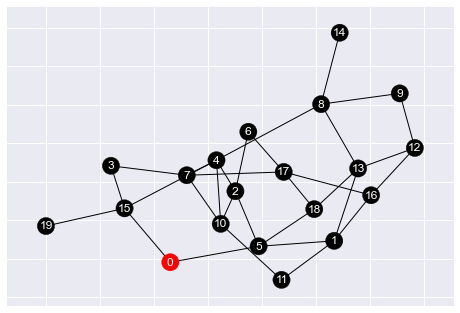

In [158]:
# 口コミが伝播した様子をネットワークに可視化（経過: 1ヶ月）

t = 0
nx.draw_networkx(
    G,
    node_color=active_node_coloring(list_time_series[t]),
    font_color="white"
)
plt.show()

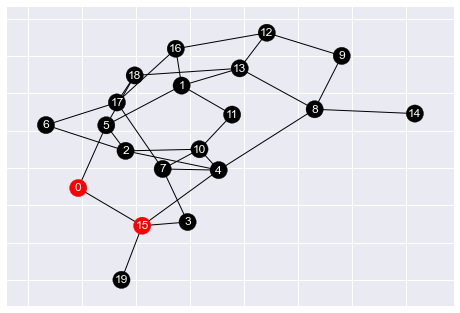

In [159]:
# 口コミが伝播した様子をネットワークに可視化（経過: 11ヶ月）

t = 11
nx.draw_networkx(
    G,
    node_color=active_node_coloring(list_time_series[t]),
    font_color="white"
)
plt.show()

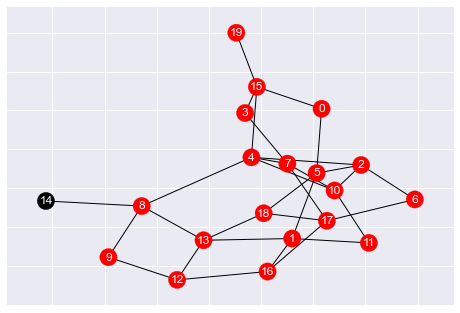

In [160]:
# 口コミが伝播した様子をネットワークに可視化（経過: 36ヶ月）

t = 35
nx.draw_networkx(
    G,
    node_color=active_node_coloring(list_time_series[t]),
    font_color="white"
)
plt.show()

### Knock73: 口コミ数の時系列変化をグラフ化する

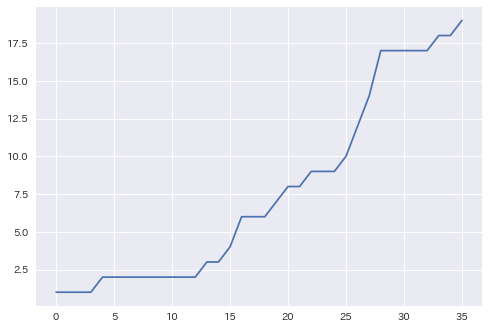

In [161]:
# 口コミ数の時系列グラフ

list_time_series_num = []
for i in range(len(list_time_series)):
    list_time_series_num.append(sum(list_time_series[i]))

plt.plot(list_time_series_num)
plt.show()

### Knock74: 会員数の時系列変化をシミュレーションする

In [165]:
# 会員数の時系列変化をシミュレーション

# 関数の定義
def simulate_population(
    num: int, list_active: list, 
    percent_percolation: float, percent_disappearance: float, 
    df_links: pd.DataFrame
):
    """
    口コミ伝播のシミュレート関数
    拡散・消滅を確率で設定する
    """
    # 拡散
    for i in range(num):
        if list_active[i] == 1:
            for j in range(num):
                if df_links.iloc[i][j] == 1:
                    if determine_link(percent_percolation) == 1:
                        list_active[j] = 1
    
    # 消滅
    for i in range(num):
        if determine_link(percent_disappearance) == 1:
            list_active[i] = 0

    return list_active

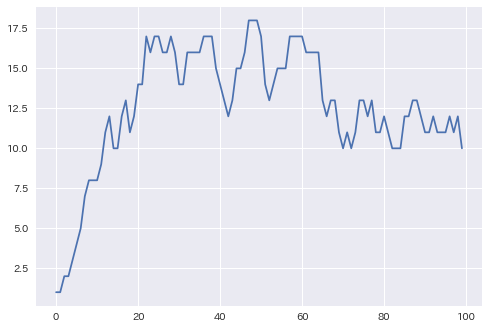

In [176]:
# シミュレーション1
percent_percolation = 0.1
percent_disappearance = 0.05
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_time_series = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_links)
    list_time_series.append(list_active.copy())

# 時系列グラフの描画

list_time_series_num = []
for i in range(len(list_time_series)):
    list_time_series_num.append(sum(list_time_series[i]))

plt.plot(list_time_series_num)
plt.show()

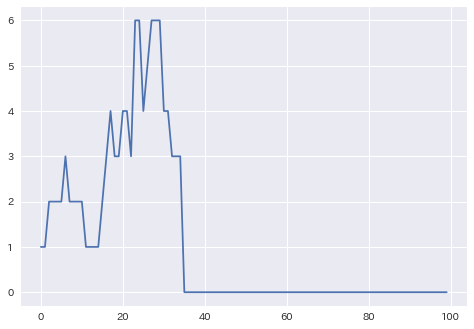

In [183]:
# シミュレーション2
percent_percolation = 0.1
percent_disappearance = 0.2
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_time_series = []
for t in range(T_NUM):
    list_active = simulate_population(
        NUM, list_active, percent_percolation, percent_disappearance, df_links
    )
    list_time_series.append(list_active.copy())

# 時系列グラフの描画

list_time_series_num = []
for i in range(len(list_time_series)):
    list_time_series_num.append(sum(list_time_series[i]))

plt.plot(list_time_series_num)
plt.show()

### Knock75: パラメータの全体像を、「相図」を見ながら把握する

In [204]:
# パラメータの全体像

# 相図の計算
print("相図計算開始")
T_NUM = 100
NUM = len(df_links.index)
NUM_PHASE_DIAGRAM = 20
phase_diagram = np.zeros((NUM_PHASE_DIAGRAM, NUM_PHASE_DIAGRAM))
for i_p in range(NUM_PHASE_DIAGRAM):
    for i_d in range(NUM_PHASE_DIAGRAM):
        percent_percolation = 0.05 * i_p
        percent_disappearance = 0.05 * i_d
        list_active = np.zeros(NUM)
        list_active[0] = 1
        for t in range(T_NUM):
            list_active = simulate_population(
                NUM, list_active, percent_percolation, percent_disappearance, df_links
            )
            phase_diagram[i_p][i_d] = sum(list_active)
print(phase_diagram)

相図計算開始
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  0.  9. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 16. 16. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 16. 17. 10. 11.  8. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 18. 16. 17. 17.  0.  9.  8.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 18. 19. 16. 19. 12.  9.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 14. 15. 18. 14. 11. 12.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 17. 15. 10. 20. 12. 10.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 19. 15. 16. 15.  0. 11.  0.  9. 13.  6.  0.  0. 

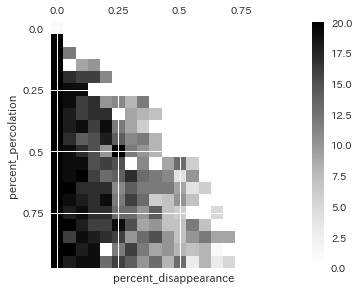

In [205]:
# 表示
plt.matshow(phase_diagram)
plt.colorbar(shrink=0.8)
plt.xlabel("percent_disappearance")
plt.ylabel("percent_percolation")
plt.xticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.yticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.tick_params(bottom=False, left=False, right=False, top=False)
plt.show()

### Knock76: 実データを読み込む

- スポーツジムの会員全体の実データを用いたシミュレーション

In [206]:
# データの読み込み

# 会員540人それぞれのSNSでのつながり 
df_members_links = pd.read_csv("../support/8章/links_members.csv", index_col="Node")
# 会員540人の24ヶ月の利用状況（1:利用月, 2:非利用月）
df_members_info = pd.read_csv("../support/8章/info_members.csv", index_col="Node")

print(df_members_links.shape)
display(df_members_links)
print(df_members_info.shape)
display(df_members_info)

(540, 540)


,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,Node10,Node11,Node12,Node13,Node14,Node15,Node16,Node17,Node18,Node19,Node20,Node21,Node22,Node23,Node24,Node25,Node26,Node27,Node28,Node29,Node30,Node31,Node32,Node33,Node34,Node35,Node36,Node37,Node38,Node39,Node40,Node41,Node42,Node43,Node44,Node45,Node46,Node47,Node48,Node49,Node50,Node51,Node52,Node53,Node54,Node55,Node56,Node57,Node58,Node59,Node60,Node61,Node62,Node63,Node64,Node65,Node66,Node67,Node68,Node69,Node70,Node71,Node72,Node73,Node74,Node75,Node76,Node77,Node78,Node79,Node80,Node81,Node82,Node83,Node84,Node85,Node86,Node87,Node88,Node89,Node90,Node91,Node92,Node93,Node94,Node95,Node96,Node97,Node98,Node99,Node100,Node101,Node102,Node103,Node104,Node105,Node106,Node107,Node108,Node109,Node110,Node111,Node112,Node113,Node114,Node115,Node116,Node117,Node118,Node119,Node120,Node121,Node122,Node123,Node124,Node125,Node126,Node127,Node128,Node129,Node130,Node131,Node132,Node133,Node134,Node135,Node136,Node137,Node138,Node139,Node140,Node141,Node142,Node143,Node144,Node145,Node146,Node147,Node148,Node149,Node150,Node151,Node152,Node153,Node154,Node155,Node156,Node157,Node158,Node159,Node160,Node161,Node162,Node163,Node164,Node165,Node166,Node167,Node168,Node169,Node170,Node171,Node172,Node173,Node174,Node175,Node176,Node177,Node178,Node179,Node180,Node181,Node182,Node183,Node184,Node185,Node186,Node187,Node188,Node189,Node190,Node191,Node192,Node193,Node194,Node195,Node196,Node197,Node198,Node199,Node200,Node201,Node202,Node203,Node204,Node205,Node206,Node207,Node208,Node209,Node210,Node211,Node212,Node213,Node214,Node215,Node216,Node217,Node218,Node219,Node220,Node221,Node222,Node223,Node224,Node225,Node226,Node227,Node228,Node229,Node230,Node231,Node232,Node233,Node234,Node235,Node236,Node237,Node238,Node239,Node240,Node241,Node242,Node243,Node244,Node245,Node246,Node247,Node248,Node249,Node250,Node251,Node252,Node253,Node254,Node255,Node256,Node257,Node258,Node259,Node260,Node261,Node262,Node263,Node264,Node265,Node266,Node267,Node268,Node269,Node270,Node271,Node272,Node273,Node274,Node275,Node276,Node277,Node278,Node279,Node280,Node281,Node282,Node283,Node284,Node285,Node286,Node287,Node288,Node289,Node290,Node291,Node292,Node293,Node294,Node295,Node296,Node297,Node298,Node299,Node300,Node301,Node302,Node303,Node304,Node305,Node306,Node307,Node308,Node309,Node310,Node311,Node312,Node313,Node314,Node315,Node316,Node317,Node318,Node319,Node320,Node321,Node322,Node323,Node324,Node325,Node326,Node327,Node328,Node329,Node330,Node331,Node332,Node333,Node334,Node335,Node336,Node337,Node338,Node339,Node340,Node341,Node342,Node343,Node344,Node345,Node346,Node347,Node348,Node349,Node350,Node351,Node352,Node353,Node354,Node355,Node356,Node357,Node358,Node359,Node360,Node361,Node362,Node363,Node364,Node365,Node366,Node367,Node368,Node369,Node370,Node371,Node372,Node373,Node374,Node375,Node376,Node377,Node378,Node379,Node380,Node381,Node382,Node383,Node384,Node385,Node386,Node387,Node388,Node389,Node390,Node391,Node392,Node393,Node394,Node395,Node396,Node397,Node398,Node399,Node400,Node401,Node402,Node403,Node404,Node405,Node406,Node407,Node408,Node409,Node410,Node411,Node412,Node413,Node414,Node415,Node416,Node417,Node418,Node419,Node420,Node421,Node422,Node423,Node424,Node425,Node426,Node427,Node428,Node429,Node430,Node431,Node432,Node433,Node434,Node435,Node436,Node437,Node438,Node439,Node440,Node441,Node442,Node443,Node444,Node445,Node446,Node447,Node448,Node449,Node450,Node451,Node452,Node453,Node454,Node455,Node456,Node457,Node458,Node459,Node460,Node461,Node462,Node463,Node464,Node465,Node466,Node467,Node468,Node469,Node470,Node471,Node472,Node473,Node474,Node475,Node476,Node477,Node478,Node479,Node480,Node481,Node482,Node483,Node484,Node485,Node486,Node487,Node488,Node489,Node490,Node491,Node492,Node493,Node494,Node495,Node496,Node497,Node498,Node499,Node500,Node501,Node502,Node503,Node504,Node505,Node506,Node507,Node508,Node509,Node510,Node511,Node512,Node5

(540, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Node,,,,,,,,,,,,,,,,,,,,,,,,
Node0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0
Node1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Node2,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
Node3,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0
Node4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Node535,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Node536,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
Node537,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,0


### Knock77: リンク数の分布を可視化する

- ネットワーク構造
  - スモールワールド型
    - わずかなステップで全員とつながる
  - スケールフリー型
    - 少数のつながりを極めて多く持つ人がハブになる

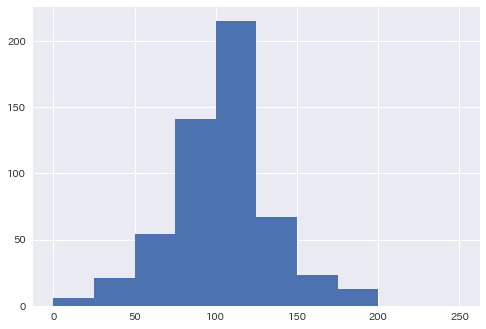

In [207]:
# リンク数の分布

NUM = len(df_members_links.index)
array_link_num = np.zeros(NUM)
for i in range(NUM):
    array_link_num[i] = sum(df_members_links["Node" + str(i)])

plt.hist(array_link_num, bins=10, range=(0, 250))
plt.show()

### Knock78: シミュレーションのために実データからパラメータを推定する

In [214]:
# 定数の設定

NUM = len(df_members_links.index)
T_NUM = len(df_members_info.columns) - 1

In [215]:
# 消滅の確率の推定

count_active = 0
count_active_to_inactive = 0
for t in range(T_NUM):
    for i in range(NUM):
        if df_members_info.iloc[i][t] == 1:
            count_active_to_inactive += 1
            if df_members_info.iloc[i][t+1] == 0:
                count_active += 1
estimated_percent_disappearance = count_active / count_active_to_inactive

In [216]:
# 拡散の確率の推定

count_link = 0
count_link_to_active = 0
count_link_temp = 0
for t in range(T_NUM):
    df_link_t = df_members_info[df_members_info[str(t)] == 1]
    temp_flag_count = np.zeros(NUM)
    for i in range(len(df_link_t.index)):
        index_i = int(df_link_t.index[i].replace("Node", ""))
        df_link_temp = df_members_links[df_members_links["Node" + str(index_i)] == 1]
        for j in range(len(df_link_temp.index)):
            index_j = int(df_link_temp.index[j].replace("Node", ""))
            if df_members_info.iloc[index_j][t] == 0:
                if temp_flag_count[index_j] == 0:
                    count_link += 1
                if df_members_info.iloc[index_j][t+1] == 1:
                    if temp_flag_count[index_j] == 0:
                        temp_flag_count[index_j] = 1
                        count_link_to_active += 1
estimated_percent_percolation = count_link_to_active / count_link

In [217]:
print(estimated_percent_disappearance)
print(estimated_percent_percolation)

0.10147163541419416
0.039006364196263604


### Knock79: 実データとシミュレーションを比較する

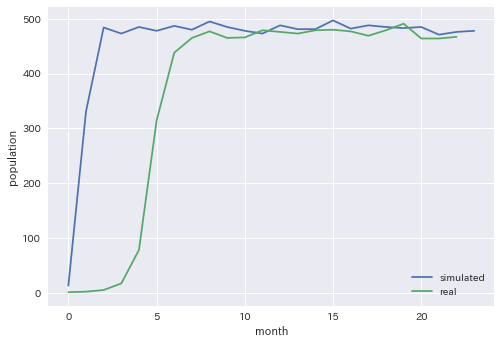

In [219]:
# 推定した確率を用いたシミュレーション

percent_percolation = estimated_percent_percolation
percent_disappearance = estimated_percent_disappearance
T_NUM = 24
NUM = len(df_members_info.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_time_series = []
for t in range(T_NUM):
    list_active = simulate_population(
        NUM, list_active, percent_percolation, percent_disappearance, df_members_links
    )
    list_time_series.append(list_active.copy())

list_time_series_num = []
for i in range(len(list_time_series)):
    list_time_series_num.append(sum(list_time_series[i]))

T_NUM = len(df_members_info.columns) - 1
list_time_series_num_real = []
for t in range(0, T_NUM):
    list_time_series_num_real.append(len(df_members_info[df_members_info[str(t)] == 1].index))

plt.plot(list_time_series_num, label="simulated")
plt.plot(list_time_series_num_real, label="real")
plt.xlabel("month")
plt.ylabel("population")
plt.legend(loc="lower right")
plt.show()

### Knock80: シミュレーションによる将来予測を実施する

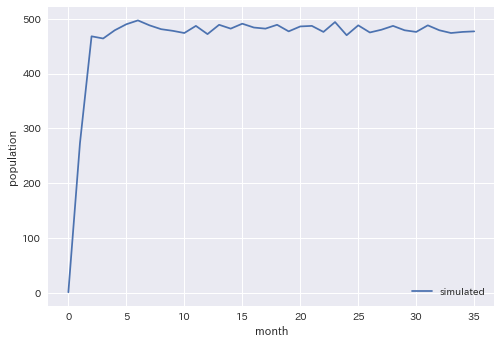

In [221]:
# シミュレーションによる将来予測

percent_percolation = estimated_percent_percolation
percent_disappearance = estimated_percent_disappearance
T_NUM = 36
NUM = len(df_members_info.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_time_series = []
for t in range(T_NUM):
    list_active = simulate_population(
        NUM, list_active, percent_percolation, percent_disappearance, df_members_links
    )
    list_time_series.append(list_active.copy())

list_time_series_num = []
for i in range(len(list_time_series)):
    list_time_series_num.append(sum(list_time_series[i]))

plt.plot(list_time_series_num, label="simulated")
plt.xlabel("month")
plt.ylabel("population")
plt.legend(loc="lower right")
plt.show()